<a href="https://colab.research.google.com/github/MothSleath/EmbeddedAI/blob/LeLucif3rBranch/third_part_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('ai4i2020.csv')

# Display the head of the dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# Preprocess the DataFrame
# Create the 'Operating machine' column as the complement of 'Machine failure'
df['Operating machine'] = 1 - df['Machine failure']

# Define label columns and columns to drop for features
label_cols = ['Operating machine', 'TWF', 'HDF', 'PWF', 'OSF']
drop_cols = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Filter rows where exactly one label is active among the selected label columns
filtered_df = df[df[label_cols].sum(axis=1) == 1]

# Select features (X) and the multi-label target (Y)
X = filtered_df.drop(columns=drop_cols)
Y = filtered_df[label_cols]

# Apply one-hot encoding to categorical features in X
X = pd.get_dummies(X)

# Convert Multi-label to Single Label
# Define a mapping for converting column names to numeric labels
label_mapping = {
    'Operating machine': 1,
    'TWF': 2,
    'HDF': 3,
    'PWF': 4,
    'OSF': 5
}

# For each row, find the active label (the column with the maximum value, i.e. 1)
# and map its name to the corresponding numeric code.
Y_single_label = Y.idxmax(axis=1).map(label_mapping)
print("Single label distribution before resampling:", Counter(Y_single_label))

# Resample Data Using SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy='auto', random_state=42)
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)

resample_pipeline = Pipeline([
    ('smote', smote),
    ('undersample', undersample)
])

# Apply the pipeline to the data (X and Y_single_label)
X_resampled, Y_resampled = resample_pipeline.fit_resample(X, Y_single_label)
print("Resampled label distribution:", Counter(Y_resampled))


# Convert Y_resampled to one-hot encoding (if needed later, e.g., for some neural network frameworks)
num_classes = 5
Y_resampled_one_hot = np.eye(num_classes)[Y_resampled - 1]

# Split the resampled data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled_one_hot,
                                                    test_size=0.3, random_state=42)
X_val, X_test, Y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=0.5, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Single label distribution before resampling: Counter({1: 9661, 3: 106, 4: 80, 5: 78, 2: 43})
Resampled label distribution: Counter({1: 9661, 2: 9661, 3: 9661, 4: 9661, 5: 9661})
Training set size: 33813
Testing set size: 7246


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │       2,554,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,596,101 (9.90 MB)

 Trainable params: 2,596,101 (9.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.2613 - loss: 8.3631 - val_accuracy: 0.5298 - val_loss: 1.1661
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.4807 - loss: 1.1691 - val_accuracy: 0.7796 - val_loss: 0.6238
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.7077 - loss: 0.7409 - val_accuracy: 0.8468 - val_loss: 0.4250
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.7775 - loss: 0.5974 - val_accuracy: 0.9219 - val_loss: 0.2455
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.8250 - loss: 0.4760 - val_accuracy: 0.9044 - val_loss: 0.2576
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.8569 - loss: 0.4125 - val_accuracy: 0.9151 - val_loss: 0.2729
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.8661 - loss: 0.3880 - val_accuracy: 0.8694 - val_loss: 0.3515
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.8624 - loss: 0.3888 - 


Test Loss: 0.1497
Test Accuracy: 0.9398
Model saved as predictive_maintenance_model_AI4I.h5


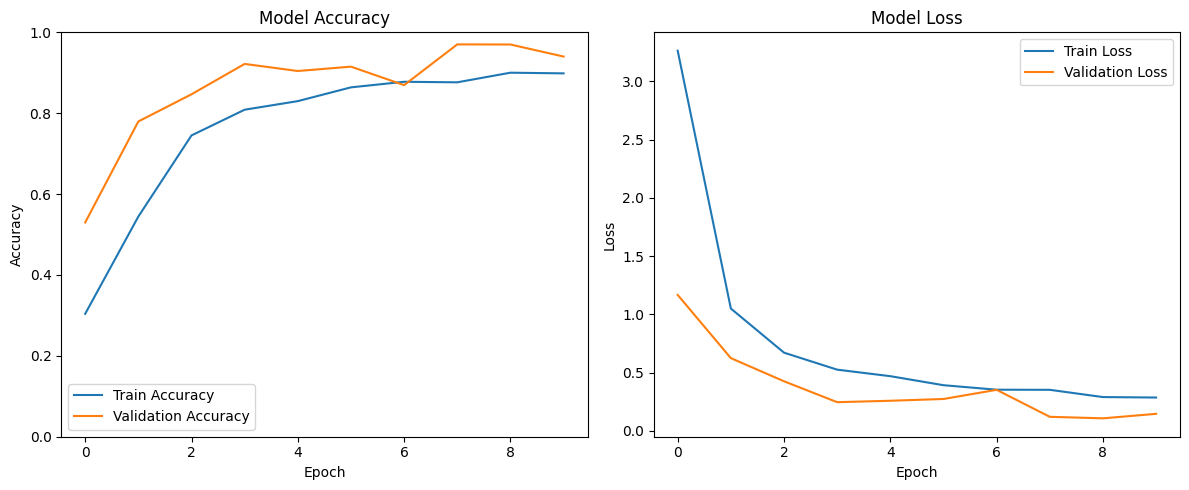

In [5]:
# Define the model architecture
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

n_epochs=10
batch_size=128

# Train the model using the training set and validation set
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, Y_val),
                    epochs=n_epochs,
                    batch_size=batch_size,
                    verbose=1)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model to a file
model.save("predictive_maintenance_model_AI4I.h5")
print("Model saved as predictive_maintenance_model_AI4I.h5")

# Plot training history: accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
                   precision    recall  f1-score   support

Operating machine       0.99      0.85      0.91      1511
              TWF       0.94      1.00      0.97      1391
              HDF       0.83      1.00      0.91      1406
              PWF       0.97      0.86      0.91      1452
              OSF       0.99      1.00      1.00      1486

         accuracy                           0.94      7246
        macro avg       0.94      0.94      0.94      7246
     weighted avg       0.95      0.94      0.94      7246



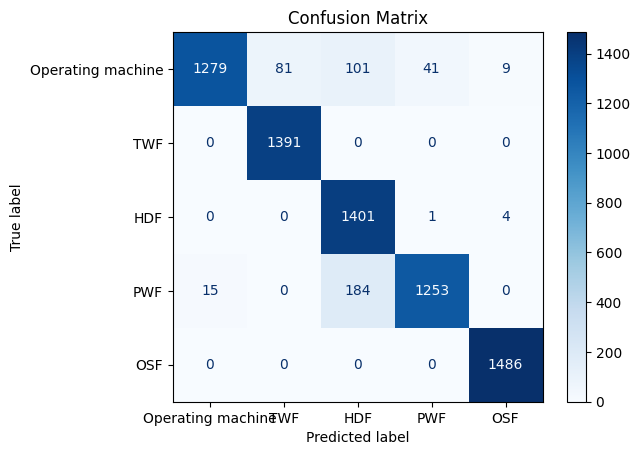

In [6]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1) + 1

y_true = np.argmax(y_test, axis=1) + 1

target_names = ['Operating machine', 'TWF', 'HDF', 'PWF', 'OSF']
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
